### 模型选择, 过拟合/欠拟合
1. 训练误差: training error, 对象是训练集
2. 泛化误差: generalization error, 对象是任何测试集, 但是使用测试集来近似
3. 验证数据集: validation set
4. 模型选择: model selection
5. K折叠验证: k-fold cross-validation
6. 欠拟合(underfitting): 模型未得到较低的训练误差
7. 过拟合(overfitting): 模型的训练误差远小于 泛化误差, 模型的泛化能力差, 无法应用于测试数据
8. 导致 *fiting的原因:
    - 模型复杂度: 可能过于复杂
    - 数据集大小: 可能数据不够
9. 参数下降的方式: alpha 是learning rate, lambda是 惩罚项的超参数, m是样本数 $$ w = (1 - \frac{\lambda*\alpha}{m}) * w - \frac{\alpha}{m}x(y^{'} - y) $$

例子: 三阶方程 $$y = 1.2x  - 3.4x^2  + 5.6x^3 + 5 + \epsilon$$,
噪声项 ϵ 服从均值为0、标准差为0.1的正态分布

In [72]:
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import data as gdata, loss as gloss, nn

In [58]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2),
                          nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [59]:
def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    对数 plot: 10^1, 10^-1, 10^-2
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [60]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
          '\nbias:', net[0].bias.data().asnumpy())

final epoch: train loss 0.0074220635 test loss 0.006229099
weight: [[ 1.317967  -3.3753843  5.566987 ]] 
bias: [4.966093]


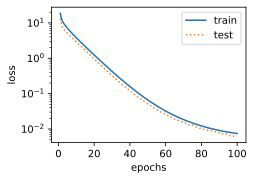

In [61]:
# 三阶多项式函数拟合
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

final epoch: train loss 46.764816 test loss 60.859554
weight: [[16.890354]] 
bias: [3.4352932]


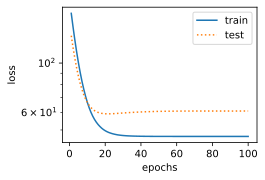

In [62]:
# 线性函数拟合(欠拟合)
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

final epoch: train loss 1.7658095 test loss 131.92845
weight: [[0.5751936  0.12406573 0.12152512]] 
bias: [3.3062701]


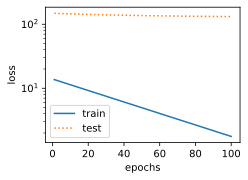

In [63]:
# 训练样本不足, 导致 过拟合
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

### 权重衰减 (损失函数加惩罚项)
1. Regularization, L2范数正则化
- L2的求导
- L2的来源: 
    - https://discuss.gluon.ai/t/topic/984/18
    - https://discuss.gluon.ai/t/topic/1793/4
- L2惩罚项怎么求导呢??
- 例子: $$ y = 0.05 + \sum_{i=1}^{p}0.01x + \epsilon $$


In [64]:
# 生成数据集: 200 维的向量
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [65]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [66]:
def l2_penalty(w):
    return (w**2).sum() / 2

def net(X, w, b):
    """Linear regression."""
    return nd.dot(X, w) + b


def sgd(params, lr, batch_size):
    """Mini-batch stochastic gradient descent."""
    for param in params:
        param[:] = param - lr * param.grad / batch_size
        
        
def squared_loss(y_hat, y):
    """平方损失函数"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [67]:
batch_size, num_epochs, lr = 1, 100, 0.003
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # 添加了L2范数惩罚项
                l = squared_loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            sgd([w, b], lr, batch_size)
        train_ls.append(squared_loss(net(train_features, w, b),
                             train_labels).mean().asscalar())
        test_ls.append(squared_loss(net(test_features, w, b),
                            test_labels).mean().asscalar())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('超参: {}, L2 norm of w: {}'.format(lambd, w.norm().asscalar()))
    return train_ls, test_ls

超参: 0, L2 norm of w: 12.8598051071167
超参: 1, L2 norm of w: 0.053903430700302124
超参: 2, L2 norm of w: 0.05683524161577225
超参: 3, L2 norm of w: 0.03447788581252098


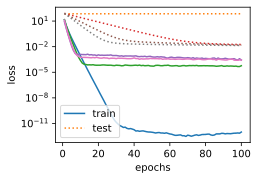

In [68]:
hyper_lambda = range(4)
for _lambda in hyper_lambda:
    # 加了惩罚项, 惩罚得很厉害
    fit_and_plot(lambd=_lambda)

### 简洁实现

In [87]:
def fit_and_plot_gluon(wd):
    """
    :param wd, weight decay
    """
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称一般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = squared_loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调用step函数，从而分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(squared_loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(squared_loss(net(test_features),
                            test_labels).mean().asscalar())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    # print("w: ", net[0].weight.data())
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
L2 norm of w: 0.061424516
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X sha

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1, 200)
X shape:  (1

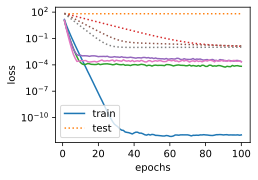

In [88]:
for wd in range(4):
    fit_and_plot_gluon(wd)

In [78]:
features.shape

(120, 200)

In [79]:
labels.shape

(120, 1)

In [81]:
for X, y in train_iter:
    break

In [86]:
X


[[ 1.3633896  -1.1632172  -0.9760932  -0.01516218  1.2356827   1.2367547
   0.16507827 -0.74555206  0.48442677 -1.5836663   1.3678067  -2.3101628
  -1.2075655  -2.3829532  -0.7164611   1.0238967   0.9682453  -0.81403494
   0.70276207  1.7705576   0.44355723 -0.2013101   0.02199137 -0.04072406
  -1.5425854   0.2156035  -1.2359432   0.01206705  1.9088962   0.70281196
  -1.3320633  -0.10734066  0.508988   -1.3194275  -1.6182498   1.4563917
   0.7300344  -2.59139    -1.4992896   0.38593134 -1.3134468   0.33637246
  -0.3631729   0.8141709  -0.15393631  0.9067445  -1.0123762  -1.4411798
  -0.63486797 -2.3335302  -0.52068615 -0.7956206   0.51694065 -0.15215039
  -0.1802458  -0.57813984 -0.6187905  -0.70998037  1.1342763   0.7592495
   0.87804615 -0.09376501  0.22321704  0.7841555   0.780869   -0.1103174
   1.2621719   0.59892756 -0.17375249 -0.1334932  -0.6356254  -0.28558362
  -0.8229931  -1.7790576  -1.0501758  -1.1350257  -0.4335905   1.3201587
   0.9588348   1.1171442  -0.7657242  -0.489

In [85]:
y


[[-0.05538098]]
<NDArray 1x1 @cpu(0)>

### 练习
1. 应对过拟合的办法
    - 更多数据
    - less complexity, 合适的复杂度
    - weight decay
    - dropout(next)
2. 权重衰减对应贝叶斯里面的哪个概念
    - 贝叶斯里面的概念: 先验概率, 后验概率, 最大后验概率估计, 极大似然估计
    - 怎么和贝叶斯联系起来, 想想报警和偷车的联系, 要想有 "一旦报警, 一定是偷车"的事件, 就必然要消除其他可能诱发报警的事件
    - Sulotion: 对参数w的先验假设是w服从正态分布, ref: https://discuss.gluon.ai/t/topic/984/18
3. 调整 权重衰减超参, 观察结果
4. 